In [7]:
# O bi sempre executa isso aqui antes de começar:
# dataset = pandas.DataFrame(field1,field2,field3,...,fieldN)
# dataset = dataset.drop_duplicates()

from pandas import read_csv,DataFrame,melt
from scipy import stats
from scipy.stats import kurtosis,skew
import numpy as np
import seaborn as sns
from matplotlib.pyplot import tight_layout,subplots,show
from sklearn.preprocessing import StandardScaler,MaxAbsScaler,PowerTransformer
from blume import table

In [8]:
import dtale
%matplotlib inline

############################## exclusivo debug: ####################################################
idxName = ['id']
#catFList = ['f_27']
catFList = ['f_27',"f_07","f_08","f_09","f_10","f_11","f_12"]
#discFList = ["f_07","f_08","f_09","f_10","f_11","f_12","f_13","f_14","f_15","f_16","f_17","f_18","f_29","f_30"]
discFList = ["f_13","f_14","f_15","f_16","f_17","f_18","f_29","f_30"]
tgtFList = ["target"]
fileDir = "D:\\Projetos\\competicoes\\featureOps\\data\\tabular-playground-series-may-2022\\train.csv"
featureDF = read_csv(fileDir)
featureDF.set_index(idxName[0],inplace=True,drop=False)
numFList = list(set(featureDF.columns) - set(tgtFList) - set(discFList) - set(catFList))
#numDF = featureDF.sample(n=1000,random_state=1111)
numDF = featureDF
dataset = melt(numDF, id_vars = idxName + catFList, value_vars=numFList+discFList,value_name='numfeatures')

bi_slicer = 'f_06,None' ##nao pode ser igual por causa dos dataset[f1] vai selecionar 2 colunas, e tem funcao q so pode receber 1 coluna

dataset = dataset[dataset['variable']=='f_06']

isCorrel = True

#### mudança do melt para o tabular : ####
if isCorrel:
    dataset = numDF
    dataset['varUniqSel'] = bi_slicer
    dataset['graphSampleSize'] = 1000
    dataset['selectedTrans'] = 'StandardScaler'
    dataset['transform1'] = 'None,StandardScaler'
    dataset['possibleGraphs'] = 'histogram'
    dataset['multiSelVarCat'] = 'f_07,f_06'
    dataset.name=None
    dataset.reset_index(inplace=True,drop=True)

#x = dataset.copy()
#x.drop(columns=['id'],inplace=True)
#d = dtale.show(x)
#print(d._url)
#d.open_browser()

#recomendacoes:
#By default, Power BI loads pandas, matplotlib and os, no need to re-import it (import pandas as pd). If you do need to alias the package, create a variable, pd=pandas and then you can use pd.read_csv(..)

In [9]:
d = dtale.show(dataset)
print(d._url)
d.open_browser()

http://deskCasa:40000


In [4]:
dataset

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,...,f_27,f_28,f_29,f_30,target,varUniqSel,graphSampleSize,selectedTrans,transform1,possibleGraphs
0,106593,0.524546,-1.550722,-0.117122,-1.550372,-0.738729,-1.876035,-1.021702,4,2,...,BAABDACNCB,-127.819166,0,1,1,"None,f_06",1000,StandardScaler,"None,StandardScaler",histogram
1,335745,1.311283,0.673950,-0.729608,-0.941050,-0.588368,0.316090,-1.342482,2,2,...,AAABABFCAD,-13.680562,0,1,1,"None,f_06",1000,StandardScaler,"None,StandardScaler",histogram
2,53919,1.612604,-1.866488,-1.699679,0.236273,-1.630374,1.270482,-0.133792,6,5,...,BHAACACQEF,-4.702254,0,1,1,"None,f_06",1000,StandardScaler,"None,StandardScaler",histogram
3,807418,-0.912045,-0.391125,1.460760,-0.307071,-0.713750,0.824748,-0.382018,1,2,...,AAABCABMAB,321.782358,0,0,0,"None,f_06",1000,StandardScaler,"None,StandardScaler",histogram
4,236155,0.245105,1.492428,0.015923,-0.133820,1.262914,0.112468,-1.172301,0,0,...,ABADBBCHHA,-80.044195,0,2,0,"None,f_06",1000,StandardScaler,"None,StandardScaler",histogram
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,813659,-0.805954,0.735527,-0.333761,1.903917,0.887064,-1.993740,-1.737035,1,1,...,BBBGCBBQBC,-108.486687,1,2,1,"None,f_06",1000,StandardScaler,"None,StandardScaler",histogram
996,825075,-0.228004,-0.533709,-0.288471,-0.170450,0.368747,0.206192,-0.168379,3,2,...,BBACDABCBB,-46.847514,0,1,1,"None,f_06",1000,StandardScaler,"None,StandardScaler",histogram
997,476091,-0.310243,1.274146,-0.656702,0.322136,2.088616,1.110128,0.443487,0,2,...,BBBCABCJBB,215.611685,1,0,1,"None,f_06",1000,StandardScaler,"None,StandardScaler",histogram
998,101771,-0.543989,-0.323726,0.475156,1.527263,1.269507,-0.351037,0.231907,2,2,...,BFBBDACTBD,201.927477,1,0,0,"None,f_06",1000,StandardScaler,"None,StandardScaler",histogram


2022-07-04 14:35:27,709 - WARNING  - findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.
2022-07-04 14:35:27,737 - WARNING  - findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.


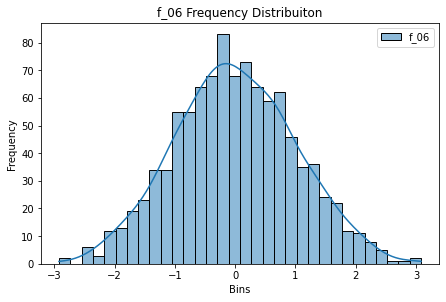

In [5]:
graph_type = dataset.at[0,'possibleGraphs']

strAllSel = dataset.at[0,'varUniqSel']
strAllSel = list(strAllSel.split(","))

try:
    strAllSel.remove('None')
except ValueError:
    pass

strAllSelCat = dataset.at[0,'multiSelVarCat']
strAllSelCat = list(strAllSel.split(","))

try:
    strAllSelCat.remove('None')
except ValueError:
    pass


samplesize = dataset.at[0,'graphSampleSize'].item()
transformer = dataset.at[0,'transform1']
transformer = list(transformer.split(","))
transformer1 = transformer[0]
transformer2 = transformer[1]

############# LOCAL FLOW : ############################################################
use_sample_size = True
#######################################################################################

dataset = dataset[strAllSel]

#garbage collector aqui? sera q as outras colunas foram mesmo deletadas?

##resolver colunas duplicadas:
if len(strAllSel)==2:
    if dataset.columns[0] == dataset.columns[1]:

        strAllSel_Correct = []
        strAllSel_Correct.append(dataset.columns[0])
        strAllSel_Correct.append(dataset.columns[1] + '_')
        dataset.columns = strAllSel_Correct
    
if use_sample_size:
    if samplesize > len(dataset):
        samplesize = len(dataset)
    dataset = dataset.sample(n=samplesize,random_state=111)

#fmeltDFNum = fmeltDFNum.groupby("variable").sample(n=sample, random_state=111)

#######################################################################################

def graph_transf():

    global dataset
    global transformer1
    global transformer2

    maxColumns = len(dataset.columns)-1
    fistCol = dataset.columns[0]
    secondCol = dataset.columns[maxColumns]
    
    transDic = {'StandardScaler':StandardScaler(),'MaxAbsScaler':MaxAbsScaler(),'PowerTransformer':PowerTransformer()} #colocar aqui os suportados

    ##################melhorar!!: 

    if transformer1 != 'None':
        scaler = transDic[transformer1]
        scaler.fit(dataset.iloc[: , 0:1])
        dataset.iloc[: , 0:1] = DataFrame(scaler.transform(dataset.iloc[: , 0:1]),columns=[fistCol])

    if transformer2 != 'None':
        scaler = transDic[transformer2]
        scaler.fit(dataset.iloc[: , maxColumns:maxColumns+1])
        dataset.iloc[: , maxColumns:maxColumns+1] = DataFrame(scaler.transform(dataset.iloc[: , maxColumns:maxColumns+1]),columns=[secondCol])

    return None

def graph_hist():

    global dataset
    selColumn = ' '.join(dataset.columns)

    binsLen = int(round(len(dataset) ** (1/2),0))
    graph = sns.histplot(data=dataset,bins=binsLen,kde=True)
    graph.set(title=selColumn+' Frequency Distribuiton')
    graph.set_xlabel("Bins")
    graph.set_ylabel("Frequency")

def graph_scatter():

    global dataset

    maxColumns = len(dataset.columns)-1
    fistCol = dataset[dataset.columns[0]] # recebe series
    secondCol = dataset[dataset.columns[maxColumns]]

    sns.scatterplot(data=dataset, x=fistCol , y=secondCol)

def graph_table():

    global dataset

    ## para uma variavel :
    #dataset = dataset[[dataset.columns[selectedVar]]]
    ## para duas :
    ## deixar queto
    
    statsx = dataset.describe().T
    statsx['sum'] = dataset.sum()
    statsx['median'] = dataset.median()
    mode = dataset.mode().values
    statsx['mode'] = np.nan if len(mode) > 1 else mode[0]
    statsx['var'] = dataset.var()
    statsx['sem'] = dataset.sem()
    statsx['kurt'] = dataset.apply(kurtosis)
    statsx['skew'] = dataset.apply(skew)
    statsx['uniques'] = dataset.nunique()

    sequential_diffs = dataset.diff() #"pulo" entre rows
    sequential_diffs.sort_values(by=list(sequential_diffs.columns),ascending=False,inplace=True) #nao faz sentido quando tem 2 
    statsx['min_diff']= sequential_diffs.min()
    statsx['max_diff']= sequential_diffs.max()
    statsx['avg_diff'] = sequential_diffs.mean()

    statsx = statsx.T
    statsx = statsx.round(decimals=2)
    statsx=DataFrame(statsx,columns=list(dataset.columns))

    fig, ax = subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    ax.figure.set_size_inches(2.8, 5) #w,h
    print(statsx.head(5))
    #cores da tabela:
    colors_cell = [['#FAFAFA']*len(statsx.columns)]*len(statsx)
    colors_rows = ['#FAFAFA']*len(statsx)
    colors_cols = ['#FAFAFA']*len(statsx.columns)

    print(statsx.values.tolist())
    print(type(statsx.values))
    print(list(statsx.columns))
    print(type(statsx.columns))
    print(list(statsx.index))
    print(type(statsx.index))

    #inferno na terra (formatacao da tabela com o matplotlib):
    #talvez formatar por celula, for i in cells, seja melhor
    tablex = table.table(ax,cellText=statsx.values, colLabels=statsx.columns,rowLabels=statsx.index,cellLoc='center',loc='center'
                        ,cellColours=colors_cell,rowColours=colors_rows,colColours=colors_cols)
    tablex.auto_set_font_size(False)
    tablex.set_fontsize(16)
    tablex.scale(1,1) #(COLUMN,ROW)

def graph_barPlot_Cat():

    global dataset
    maxColumns = len(dataset.columns)-1
    fistCol = dataset[dataset.columns[0]] # recebe series

    dataset = dataset.groupby(dataset.columns[0])[['f_02']].agg(['count', 'mean'])

    #sns.set_theme(style="whitegrid")
    #sns.barplot(x=("f_02",'mean'), y=("f_02",'count'), data=featureDF,estimator=np.mean,ci=None)
    ax1 = sns.barplot(x=dataset.index, y=("f_02",'mean'), data=dataset,estimator=np.mean,ci=None)
    ax2 = ax1.twinx()
    sns.lineplot(data = dataset[("f_02",'count')], marker='o', sort = False, ax=ax2)
    show()

def graph_qqplot():

    global dataset
    fistCol = dataset[dataset.columns[0]] # precisa receber 1 serie, nao recebe 2.
    stats.probplot(fistCol, plot=sns.mpl.pyplot)

def graph_jointplot():

    global dataset

    maxColumns = len(dataset.columns)-1
    fistCol = dataset[dataset.columns[0]] # recebe series
    secondCol = dataset[dataset.columns[maxColumns]]

    sns.jointplot(x=fistCol, y=secondCol,data=dataset,kind="reg",truncate=False)

def graph_boxplot():

    global dataset
    sns.boxplot(data=dataset,orient='vertical')

############## GLOBAL FLOW : ##########################################################
possibleGraphs = {'histogram':graph_hist,'qqplot':graph_qqplot,'boxplot':graph_boxplot,'table':graph_table,'scatter':graph_scatter,'jointplot':graph_jointplot}
#######################################################################################

graph_transf()
possibleGraphs[graph_type]()
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
tight_layout(pad=0, w_pad=0, h_pad=0)
show()

In [6]:
selColumn = dataset.columns[0]